### Load a manipulator in MuJoCo

In [1]:
import glfw,os,time,mujoco,mujoco_py
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
np.set_printoptions(precision=2)
from screeninfo import get_monitors
from pid import PID_ControllerClass
from util import pr2T
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.2.0]


### Parse useful information

In [2]:
# Load Panda xml
cwd      = os.getcwd() # current folder path
xml_path = os.path.join(cwd,'../asset/panda/franka_panda.xml')
mj_model = mujoco_py.load_model_from_path(xml_path)
sim      = mujoco_py.MjSim(mj_model)
print ("[%s] loaded."%(xml_path))
# Parse information
dt              = sim.model.opt.timestep
HZ              = int(1/dt)
body_names      = list(sim.model.body_names)
ee_name         = 'panda_eef'
n_joint         = sim.model.njnt
joint_names     = [sim.model.joint_id2name(x) for x in range(n_joint)]
joint_types     = sim.model.jnt_type # 0:free, 1:ball, 2:slide, 3:hinge
rev_joint_idxs  = np.where(joint_types==3)[0].astype(np.int32) # revolute joint
rev_joint_names = [joint_names[x] for x in rev_joint_idxs]
rev_qvel_idxs   = [sim.model.get_joint_qvel_addr(x) for x in rev_joint_names]
n_rev_joint     = len(rev_joint_idxs)
grp_joint_idxs  = np.where(joint_types==2)[0].astype(np.int32) # gripper joint
grp_joint_names = [joint_names[x] for x in grp_joint_idxs]
joint_range     = sim.model.jnt_range
torque_range    = sim.model.actuator_ctrlrange
# Print-out useful information
print ("dt:[%.3f] HZ:[%d]"%(dt,HZ))
print ("body_names:\n%s"%(body_names))
print ("ee_name         :%s"%(ee_name))
print ("")
print ("n_joint         : [%d]"%(n_joint))
print ("joint_names     : %s"%(joint_names))
print ("joint_types     : %s"%(joint_types))
print ("n_rev_joint     : [%d]"%(n_rev_joint))
print ("rev_joint_idxs  : %s"%(rev_joint_idxs))
print ("rev_joint_names : %s"%(rev_joint_names))
print ("grp_joint_idxs  : %s"%(grp_joint_idxs))
print ("grp_joint_names : %s"%(grp_joint_names))
print ("")
print ("joint_range:\n%s"%(joint_range))
print ("torque_range:\n%s"%(torque_range))
print ("torque_range:\n%s"%(torque_range))

[/Users/sj/Dropbox/SJ/Research/Implementation/simple-mujoco-usage/code/../asset/panda/franka_panda.xml] loaded.
dt:[0.002] HZ:[500]
body_names:
['world', 'panda_base', 'panda_pedestal', 'panda_link_0', 'panda_link_1', 'panda_link_2', 'panda_link_3', 'panda_link_4', 'panda_link_5', 'panda_link_6', 'panda_link_7', 'right_hand', 'panda_right_gripper', 'panda_eef', 'panda_leftfinger', 'panda_finger_joint1_tip', 'panda_rightfinger', 'panda_finger_joint2_tip']
ee_name         :panda_eef

n_joint         : [9]
joint_names     : ['panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7', 'panda_finger_joint1', 'panda_finger_joint2']
joint_types     : [3 3 3 3 3 3 3 2 2]
n_rev_joint     : [7]
rev_joint_idxs  : [0 1 2 3 4 5 6]
rev_joint_names : ['panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7']
grp_joint_idxs  : [7 8]
grp_joint_names : ['panda_finger_joint1', 'panda_finger_joint2']


In [3]:
def open_gripper(): sim.data.ctrl[grp_joint_idxs] = np.array([0.04,-0.04])
def close_gripper(): sim.data.ctrl[grp_joint_idxs] = np.array([0.00,-0.00])
print ("Done.")

Done.


### Joint PID control

In [8]:
# Set viewer
glfw.terminate() # terminate before initialize
glfw.init()      # initialize glfw
viewer   = mujoco_py.MjViewer(sim)
glfw.set_window_size(window = viewer.window,
                     width  = int(0.5*get_monitors()[0].width),
                     height = int(0.5*get_monitors()[0].height))
# PID controller
PID = PID_ControllerClass(
    name    = 'PID',
    k_p     = 500.0,
    k_i     = 0.0,
    k_d     = 100.0, # <= D gain is super important
    dim     = n_rev_joint,
    out_min = torque_range[rev_joint_idxs,0],
    out_max = torque_range[rev_joint_idxs,1],
    ANTIWU  = True)
# Desired position
q_des = np.array([0,0,0,-90,0,90,0])*np.pi/180.0
# Loop
sim.reset() # reset sim
tick,tic,max_sec = 0,time.time(),10.0
q_curr_list  = np.zeros(shape=(int(HZ*max_sec)+1,PID.dim))
q_des_list   = np.zeros(shape=(int(HZ*max_sec)+1,PID.dim))
sec_sim_list = np.zeros(shape=(int(HZ*max_sec)+1))
torque_list  = np.zeros(shape=(int(HZ*max_sec)+1,PID.dim))
while True:
    # Current state
    sec_wall  = time.time() - tic
    sim_state = sim.get_state()
    sec_sim   = sim_state.time
    q_curr    = sim_state.qpos[rev_joint_idxs]
    p_EE      = np.array(sim.data.body_xpos[sim.model.body_name2id(ee_name)])
    R_EE      = np.array(sim.data.body_xmat[sim.model.body_name2id(ee_name)].reshape([3, 3]))
    T_EE      = pr2T(p=p_EE,R=R_EE)
    J_p_EE    = np.array(sim.data.get_body_jacp(ee_name).reshape((3, -1))[:,rev_qvel_idxs])
    J_R_EE    = np.array(sim.data.get_body_jacr(ee_name).reshape((3, -1))[:,rev_qvel_idxs])
    J_full_EE = np.array(np.vstack([J_p_EE,J_R_EE]))
    # Print
    VERBOSE = 3
    if ((tick%HZ)==0):
        if (VERBOSE>=1):
            print ("sec_wall:[%.3f]sec, sec_sim:[%.3f]sec"%(sec_wall,sec_sim))
        if (VERBOSE>=2):
            print ("q_curr:  %s"%(q_curr))
            print ("p_EE:    %s"%(p_EE))
            print ("R_EE:   \n%s"%(R_EE))
            print ("T_EE:   \n%s"%(T_EE))
        if (VERBOSE>=3):
            print ("J_p_EE: \n%s"%(J_p_EE))
            print ("J_R_EE: \n%s"%(J_p_EE))
            print ("J_full_EE: \n%s"%(J_full_EE))
            print ("")
    # Control revolute joint
    PID.update(x_trgt=q_des)
    PID.update(t_curr=sec_sim,x_curr=q_curr,VERBOSE=False)
    torque = PID.out()
    sim.data.ctrl[rev_joint_idxs] = torque
    # Control gripper
    if sec_sim < 5.0: open_gripper()
    else: close_gripper()
    # Append
    q_curr_list[tick,:] = q_curr
    q_des_list[tick,:]  = q_des
    sec_sim_list[tick]  = sec_sim
    torque_list[tick,:] = torque
    # Add marker
    viewer.add_marker(pos   = p_EE,
                      type  = 2, # mjtGeom: 2:sphere, 3:capsule, 6:box, 9:arrow
                      size  = 0.02*np.ones(3),
                      rgba  = np.array([0.0,1.0,0.0,1.0]),
                      label = 'EE-Tip')
    # Step
    sim.step()
    render_speedup = 1
    if (sec_sim >= render_speedup*sec_wall): # wall-clock sync
        viewer.render() 
    if (sec_sim >= max_sec): break
    tick = tick + 1 # tick starts from 0
print ("Done.")

Creating window glfw
sec_wall:[0.000]sec, sec_sim:[0.000]sec
q_curr:  [0. 0. 0. 0. 0. 0. 0.]
p_EE:    [0. 0. 0.]
R_EE:   
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
T_EE:   
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]
J_p_EE: 
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
J_R_EE: 
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
J_full_EE: 
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]

sec_wall:[0.917]sec, sec_sim:[1.000]sec
q_curr:  [-1.66e-05  5.68e-02 -2.06e-05 -1.60e+00 -3.62e-05  1.56e+00 -4.61e-04]
p_EE:    [ 5.57e-01 -2.82e-05  1.40e+00]
R_EE:   
[[-7.04e-01  7.03e-01 -1.00e-01]
 [ 7.06e-01  7.08e-01 -3.40e-05]
 [ 7.07e-02 -7.07e-02 -9.95e-01]]
T_EE:   
[[-7.04e-01  7.03e-01 -1.00e-01  5.57e-01]
 [ 7.06e-01  7.08e-01 -3.40e-05 -2.82e-05]
 [ 7.07e-02 -7.07e-02 -9.95e-01  1.40e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+0

sec_wall:[6.996]sec, sec_sim:[7.000]sec
q_curr:  [ 1.37e-11  5.48e-02  1.24e-08 -1.61e+00  2.25e-07  1.57e+00 -2.20e-08]
p_EE:    [5.58e-01 4.58e-08 1.40e+00]
R_EE:   
[[-7.04e-01  7.03e-01 -9.72e-02]
 [ 7.07e-01  7.07e-01  2.25e-07]
 [ 6.88e-02 -6.87e-02 -9.95e-01]]
T_EE:   
[[-7.04e-01  7.03e-01 -9.72e-02  5.58e-01]
 [ 7.07e-01  7.07e-01  2.25e-07  4.58e-08]
 [ 6.88e-02 -6.87e-02 -9.95e-01  1.40e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
J_p_EE: 
[[-4.58e-08  1.46e-01 -4.57e-08  1.65e-01  4.27e-09  2.11e-01  1.76e-19]
 [ 5.58e-01  0.00e+00  5.49e-01  0.00e+00  2.04e-01 -1.96e-08  0.00e+00]
 [ 0.00e+00 -5.58e-01  2.51e-09  4.58e-01  4.56e-08  6.78e-02 -1.72e-20]]
J_R_EE: 
[[-4.58e-08  1.46e-01 -4.57e-08  1.65e-01  4.27e-09  2.11e-01  1.76e-19]
 [ 5.58e-01  0.00e+00  5.49e-01  0.00e+00  2.04e-01 -1.96e-08  0.00e+00]
 [ 0.00e+00 -5.58e-01  2.51e-09  4.58e-01  4.56e-08  6.78e-02 -1.72e-20]]
J_full_EE: 
[[-4.58e-08  1.46e-01 -4.57e-08  1.65e-01  4.27e-09  2.11e-01  1.76e-19]
 [ 5.58

In [9]:
glfw.terminate() # terminate

### Plot PID tracking results

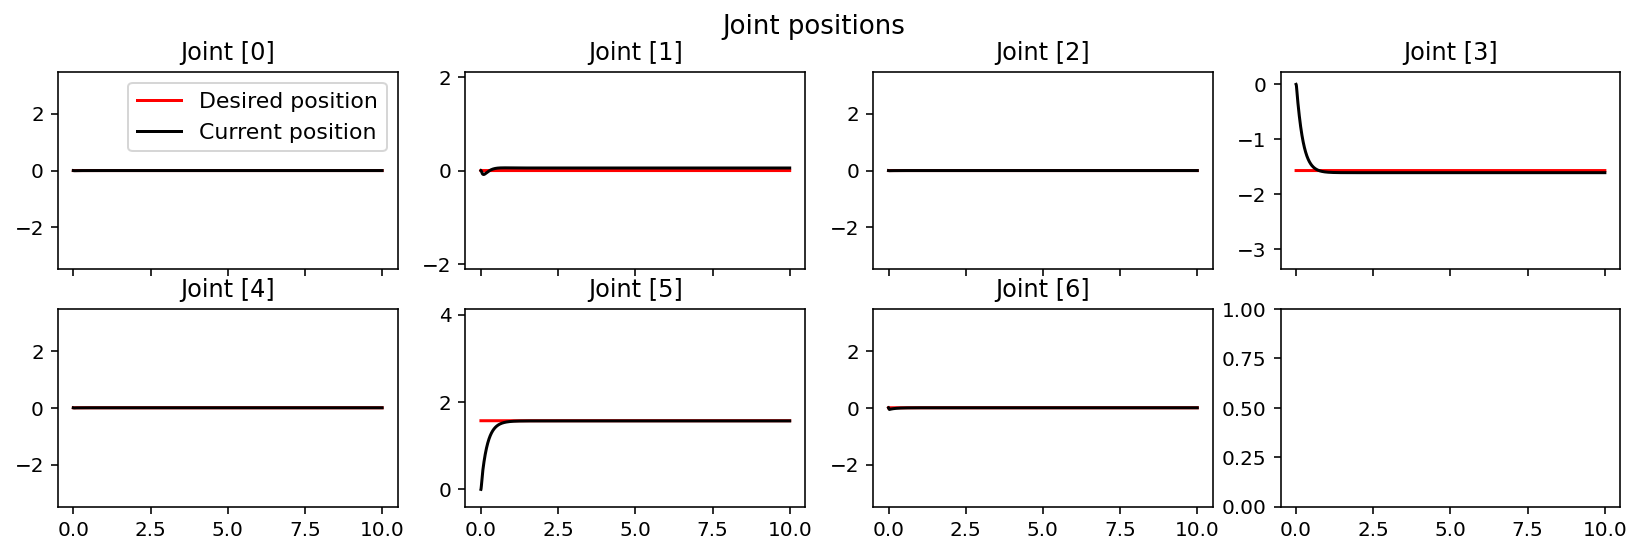

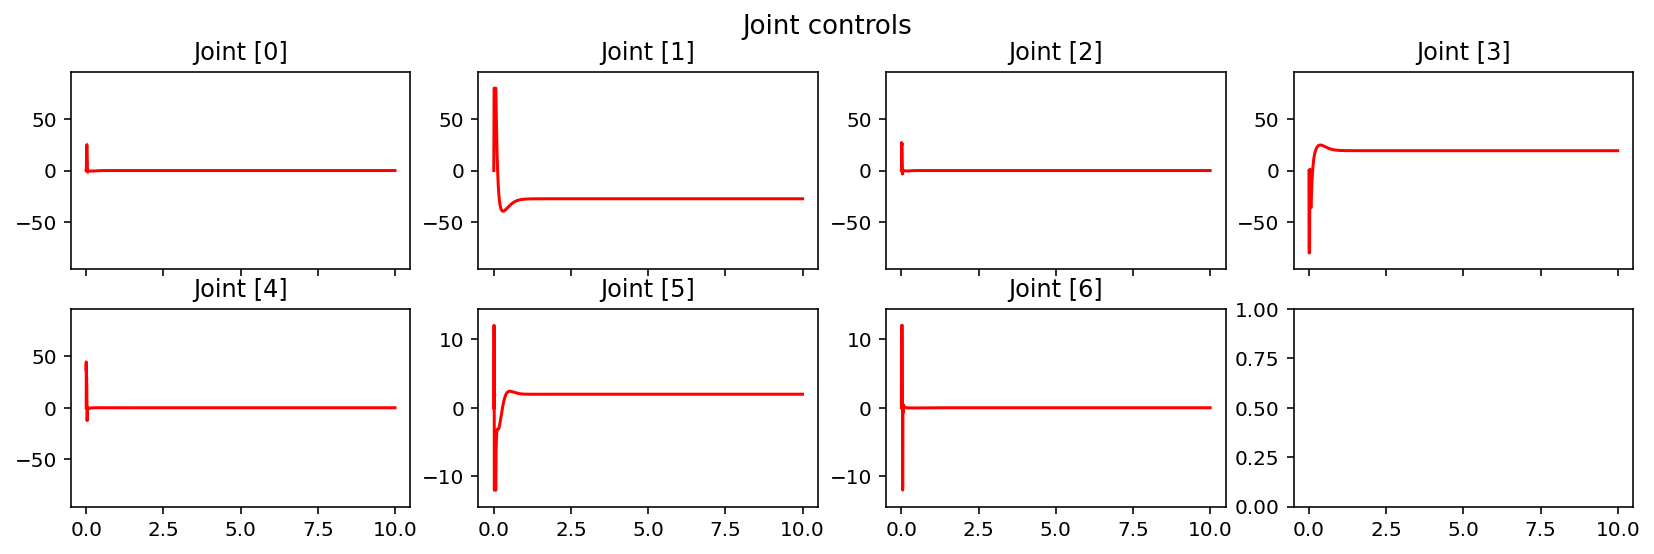

In [6]:
# Plot target and current joint position
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(14,4))
fig.suptitle("Joint positions", fontsize=13)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_sim_list,q_des_list[:,a_idx],color='r',label='Desired position')
    ax.plot(sec_sim_list,q_curr_list[:,a_idx],color='k',label='Current position')
    qmarg = 0.1*(joint_range[a_idx,1]-joint_range[a_idx,0])
    ax.set_ylim(bottom=joint_range[a_idx,0]-qmarg,top=joint_range[a_idx,1]+qmarg)
    ax.set_title('Joint [%d]'%(a_idx))
    if a_idx == 0: ax.legend(fontsize=11)
plt.show()
# Plot control output
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(14,4))
fig.suptitle("Joint controls", fontsize=13)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_sim_list,torque_list[:,a_idx],color='r')
    tmarg = 0.1*(torque_range[a_idx,1]-torque_range[a_idx,0])
    ax.set_ylim(bottom=torque_range[a_idx,0]-tmarg,top=torque_range[a_idx,1]+tmarg)
    ax.set_title('Joint [%d]'%(a_idx))
plt.show()